In [1]:
import pandas as pd
import os
os.chdir("..")
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Examine results from topic modelling 

In [14]:
datasets = {
    "annomatic": pd.read_parquet("data/enriched/annomatic_full.parquet"),
    "babe": pd.read_parquet("data/enriched/babe_full.parquet"),
    "basil": pd.read_parquet("data/enriched/basil_full.parquet")
}

topic_models = {
    "annomatic": BERTopic.load("data/enriched/models/annomatic_model", embedding_model="all-MiniLM-L6-v2"),
    "babe": BERTopic.load("data/enriched/models/babe_model", embedding_model="all-MiniLM-L6-v2"),
    "basil": BERTopic.load("data/enriched/models/basil_model", embedding_model="all-MiniLM-L6-v2")}

In [11]:
for name, df in datasets.items():
    print(df["topic"].value_counts(dropna=False))

topic
None                                                            13003
0_climate_water_climate change_energy                            1202
1_god_church_jesus_christian                                     1042
2_game_season_team_football                                       911
3_woman_mother_daughter_said                                      836
                                                                ...  
138_moon_venus_sign_scorpio                                        29
142_eu_eurosceptic_euro_european                                   28
137_loan_student loan_student_borrowers                            27
141_strike_sag_sag aftra_aftra                                     26
140_univision_reliable democrat_commercials_democrat talking       25
Name: count, Length: 146, dtype: int64
topic
0_police_black_floyd_george                  483
None                                         479
14_trump_media_donald trump_donald           204
1_transgender_women_gay_sex     

In [17]:
for name, model in topic_models.items():
    fig = model.visualize_topics()  # Generate the visualization
    fig.update_layout(title=f"Topic Visualization for {name.capitalize()}")
    fig.show()


Babe has already annotated topics. We can compare them against those to see how coherent it is.
Although the annotated topic is in the article level, and bertopic is on the sentence. So actually it can give different results but it´s accurate for the sentence.

In [27]:
babe_raw = pd.read_csv("data/raw/babe.csv", sep=";")

merged_babe = pd.merge(babe_raw, datasets["babe"], on='text', how='inner')
merged_babe = merged_babe[['text', 'topic_x', 'topic_y']]

pd.set_option('display.max_colwidth', None) 
merged_babe.head(15)

,text,topic_x,topic_y
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",environment,18_green_new deal_green new_ocasio
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",gun control,16_trump_protesters_donald_donald trump
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",white-nationalism,0_police_black_floyd_george
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",white-nationalism,20_racist_trump_racism_president
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",marriage-equality,0_police_black_floyd_george
5,[Democrats employ] their full arsenal to delegitimize the Trump presidency for the apparent crime of winning the 2016 election.,vaccine,None
6,[Newsoms's] obsession with masks has created an almost hostile environment in our neighborhoods and streets.,vaccine,None
7,[Newsoms's] onslaught of propaganda ignores conflicting science on mask-wearing (some studies suggest it may even increase infection) and vilifying those who ever leave their house with a wish to breath unimpeded oxygen as they walk down the sidewalk alone.,vaccine,None
8,"[The police] now prefer to think of themselves more like glorified social workers, there to heal the wounds of a broken society by showing off their skateboarding skills at Extinction Rebellion protests and putting on makeup and rainbow lanyards to prance embarrassingly at Gay Pride festivals.",marriage-equality,0_police_black_floyd_george
9,‘A new low’: Washington Post media critic blows up Tucker Carlson’s absurd lies about white nationalism,white-nationalism,20_racist_trump_racism_president


### Examine results from Named Entity Recognition

Wordcloud for annomatic


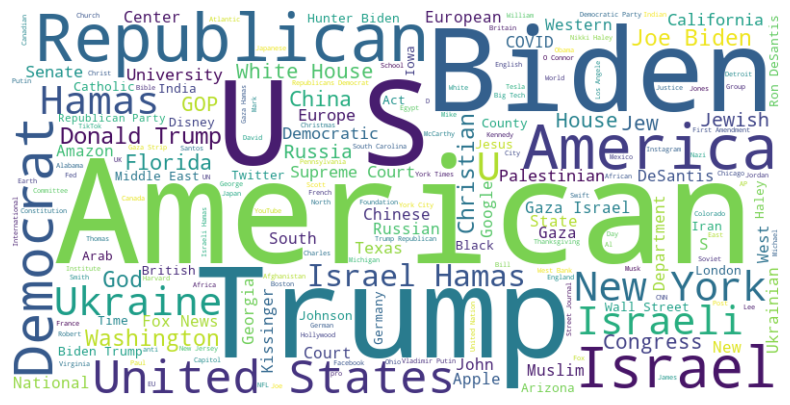

Wordcloud for babe


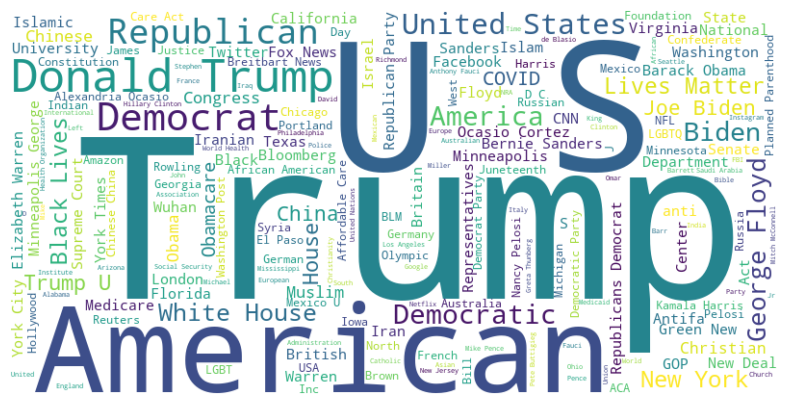

Wordcloud for basil


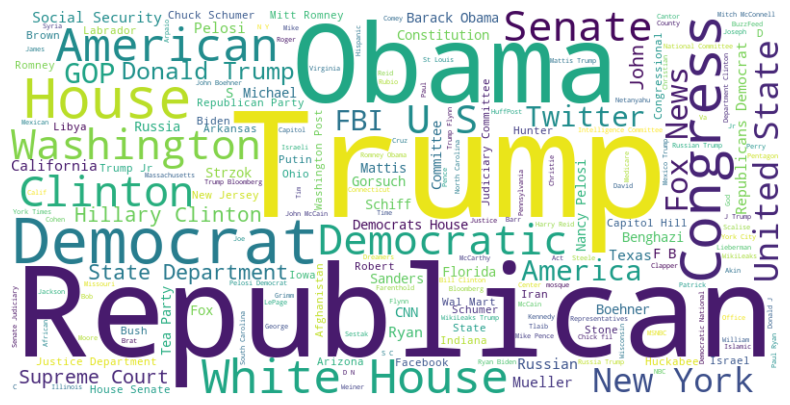

In [44]:
for name, df in datasets.items():
    all_entities = [str(entity) for entity in df["entities"].explode() if not pd.isna(entity)]
    text = ' '.join(all_entities)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    print(f"Wordcloud for {name}")
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
